# Chapter 10 - Classification

In [2]:
# Basic Libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

In [3]:
# Specific Libraries

from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

### The Dataset

In [5]:
# Titanic Dataframe

url = ("https://raw.githubusercontent.com/joanby/python-ml-course/refs/heads/master/datasets/titanic/titanic3.csv")
df = pd.read_csv(url)
orig_df = df

In [6]:
from sklearn import model_selection 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  
from sklearn.preprocessing import StandardScaler 

def tweak_titanic(df):
    # Drop unnecessary columns and convert categorical columns to dummy variables
    df = df.drop(
        columns=[
            "name",          # Drop passenger name column
            "ticket",        # Drop ticket column
            "home.dest",     # Drop home destination column
            "boat",          # Drop boat information column
            "body",          # Drop body number column
            "cabin",         # Drop cabin information column
        ]
    ).pipe(pd.get_dummies, drop_first=True)  # Convert categorical variables to dummy variables, dropping the first category
    return df                                # Return the cleaned and transformed DataFrame

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]               # Extract the target variable
    X = df.drop(columns=y_col)  # Drop target variable from feature set
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(   # Split data into training and test sets
        X, y, test_size=size, random_state=42
    )
    cols = X.columns  # Get list of feature columns
    
    num_cols = [      # List of numeric columns to impute for missing values
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = IterativeImputer()                       # Initialize IterativeImputer for imputing missing values
    fitted = fi.fit_transform(X_train[num_cols])  # Fit and transform imputer on training numeric columns
    
    # Update training DataFrame with imputed values for numeric columns
    X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])  # Transform test data using the same imputer
    
    # Update test DataFrame with imputed values for numeric columns
    X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(num_cols)})
    
    # Standardize specified columns if any are provided
    if std_cols:
        std = StandardScaler()  # Initialize StandardScaler
        fitted = std.fit_transform(X_train[std_cols])  # Fit and transform scaler on training standardization columns
        # Update training DataFrame with standardized values
        X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])     # Transform test data using the same scaler
        # Update test DataFrame with standardized values
        X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(std_cols)})

    # Return training and test sets for features and target
    return X_train, X_test, y_train, y_test

# Apply the functions to preprocess the Titanic dataset
ti_df = tweak_titanic(orig_df)                 # Clean and transform the original DataFrame
std_cols = "pclass,age,sibsp,fare".split(",")  # Specify columns to standardize

# Split the preprocessed data into training and test sets
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

# Concatenate training and test sets for features and target variables for further use
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### Logistic Regression


In [8]:
from sklearn.linear_model import LogisticRegression

# Initialize a Logistic Regression model with a fixed random state for reproducibility
lr = LogisticRegression(random_state=42)

# Fit the Logistic Regression model to the training data
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [9]:
# Calculate and return the accuracy score of the model on the test data
lr.score(X_test, y_test)

0.8015267175572519

In [10]:
# Make a prediction for the first sample in the DataFrame 'X'
lr.predict(X.iloc[[0]])

array([0], dtype=int64)

In [11]:
# Get the predicted probability for each class for the first sample in 'X'
lr.predict_proba(X.iloc[[0]])

array([[0.89758194, 0.10241806]])

In [12]:
# Get the log-probability estimates for each class for the first sample in 'X'
lr.predict_log_proba(X.iloc[[0]])

array([[-0.10805087, -2.27869218]])

In [13]:
# Calculate the decision function score for the first sample in 'X' (distance to decision boundary)
lr.decision_function(X.iloc[[0]])

array([-2.17064131])

In [14]:
# The intercept (or bias term) of the logistic regression model.
lr.intercept_ 

array([1.28437582])

In [15]:
def inv_logit(p):                     # Define the inverse logit (sigmoid) function
    return np.exp(p) / (1 + np.exp(p)) # Calculate the inverse logit for p

# Apply the inverse logit function to the model's intercept term
inv_logit(lr.intercept_)               # This converts the intercept from log-odds back to probability

array([0.78319372])

The intercept-only probability of 0.783 (or 78.3%) suggests that, without considering features, the model's baseline prediction would be weighted toward *not surviving*, assuming 0 indicates death and 1 indicates survival.

We can inspect the coefficients. The inverse logit of the coefficients gives the proportion of the positive cases. In this case, if
fare goes up, we are more likely to survive. If sex is male, we are less likely to survive:

In [18]:
cols = X.columns               # Get all feature names (columns) in the DataFrame X

for col, val in sorted(        # Loop over sorted pairs of (column, coefficient)
    zip(cols, lr.coef_[0]),    # Combine columns and corresponding coefficients
    key=lambda x: x[1],        # Sort by the coefficient value (second element in the pair)
    reverse=True,              # Sort in descending order to show highest coefficients first
):
    print(                                            # Print each feature's name, coefficient, and inverse logit (probability) of the coefficient
        f"{col:10}{val:10.3f} {inv_logit(val):10.3f}" # Format the output to show column name, coefficient, and transformed probability with 3 decimals
    )

fare           0.102      0.525
parch         -0.071      0.482
sibsp         -0.272      0.432
age           -0.294      0.427
embarked_Q    -0.544      0.367
embarked_S    -0.549      0.366
pclass        -0.736      0.324
sex_male      -2.435      0.081


The output shows each feature in the Titanic dataset (fare, parch, sibsp, etc.), along with two values for each:

* Coefficient Value: This is the weight or impact of each feature on the model's predictions. In logistic regression, a positive coefficient increases the probability of the target class (in this case, survival), while a negative coefficient decreases it.

* Transformed Probability (Inverse Logit): This is the probability calculated using the inverse logit (sigmoid) function on the coefficient value, indicating the "impact strength" of each feature in probability terms.

In [20]:
inv_logit(0.102) 

0.525477914477493

`fare`: Coefficient 0.102 (transformed to 0.525). A higher fare increases the probability of survival slightly.

`parch`: Coefficient -0.071 (transformed to 0.482). Having parents or children on board decreases the probability of survival slightly.

`sex_male`: Coefficient -2.435 (transformed to 0.081). Being male drastically decreases the probability of survival.

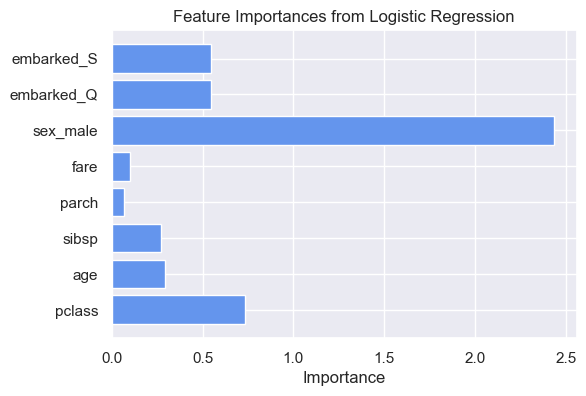

In [22]:
# Get feature importances from the logistic regression model
feature_importances = np.abs(lr.coef_[0])  # Take absolute values for easier comparison
features = X.columns

# Plot the feature importances
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(features, feature_importances, color='cornflowerblue')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances from Logistic Regression')
plt.show()

### Naive Bayes

Naive Bayes is a probabilistic classifier that *assumes independence between the features of the data*. It is popular for text
classification applications, such as catching spam. One advantage of this model is that because it assumes feature independence, it can train a model with a small number of samples. (A downside is that it can’t capture the interactions between features.) This simple model can also work with data that has many features. As such, it serves as a good baseline model.

There are three classes in sklearn: **GaussianNB**, **MultinomialNB**, and **BernoulliNB**. The first assumes a Gaussian distribution (continuous features with a normal distribution), the second is for discrete occurrence counts, and the third is for discrete Boolean features.

In [25]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()         # Initialize a Gaussian Naive Bayes model
nb.fit(X_train, y_train)  # Fit the model to the training data (X_train) and labels (y_train)

GaussianNB()

In [26]:
# Calculate the model's accuracy on the test data
nb.score(X_test, y_test)  

0.7557251908396947

In [27]:
# Predict the class label for the first instance in X
nb.predict(X.iloc[[0]])  

array([0], dtype=int64)

In [28]:
# Predict the probability of each class for the first instance in X
nb.predict_proba(X.iloc[[0]])  

array([[0.95955327, 0.04044673]])

In [29]:
# Predict the log-probability of each class for the first instance in X
nb.predict_log_proba(X.iloc[[0]])  

array([[-0.04128744, -3.20776957]])

**TIP**: These models are susceptible to the zero probability problem. If you try to classify a new sample that has no training data, it will have a zero probability. One solution is to use
Laplace smoothing. Sklearn controls this with the alpha parameter, which defaults to 1 and enables smoothing on the MultinomialNB and BernoulliNB models.

### Support Vector Machine

A Support Vector Machine (SVM) is an algorithm that tries to fit a line (or plane or hyperplane) between the different classes
that maximizes the distance from the line to the points of the classes. In this way it tries to find a robust separation between
the classes. The support vectors are the points of the edge of the dividing hyperplane.

In [33]:
from sklearn.svm import SVC

svc = SVC(random_state=42, probability=True)  # Initialize Support Vector Classifier with a random state for reproducibility and probability estimates
svc.fit(X_train, y_train)                     # Fit the model to the training data (X_train) and labels (y_train)

SVC(probability=True, random_state=42)

In [34]:
# Calculate the model's accuracy on the test data
svc.score(X_test, y_test)  

0.8015267175572519

In [35]:
# Predict the class label for the first instance in X
svc.predict(X.iloc[[0]])  

array([0], dtype=int64)

In [36]:
# Predict the probability of each class for the first instance in X
svc.predict_proba(X.iloc[[0]])  

array([[0.84756556, 0.15243444]])

In [37]:
# Predict the log-probability of each class for the first instance in X
svc.predict_log_proba(X.iloc[[0]])  

array([[-0.16538708, -1.8810207 ]])

### K-Nearest Neighbor

The K-Nearest Neighbor (KNN) algorithm classifies based on distance to some number (k) of training samples. The algorithm family is called *instance-based* learning as there are no parameters to learn. This model assumes that distance is sufficient for inference; otherwise it makes no assumptions about the underlying data or its distributions.

The tricky part is selecting the appropriate k value. Also, the curse of dimensionality can hamper distance metrics as there is
little difference in high dimensions between nearest and farthest neighbor.

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()  # Initialize a k-Nearest Neighbors Classifier
knc.fit(X_train, y_train)     # Fit the model to the training data (X_train) and labels (y_train)

KNeighborsClassifier()

In [40]:
# Calculate the model's accuracy on the test data
knc.score(X_test, y_test) 

0.7684478371501272

In [41]:
# Predict the class label for the first instance in X
knc.predict(X.iloc[[0]]) 

array([0], dtype=int64)

In [42]:
# Predict the probability of each class for the first instance in X
knc.predict_proba(X.iloc[[0]])

array([[0.8, 0.2]])

### Decision Tree

A decision tree is like going to a doctor who asks a series of questions to determine the cause of your symptoms. We can use a process to create a decision tree and have a series of questions to predict a target class. The advantages of this model include support for nonnumeric data (in some implementations), little data preparation (no need for scaling), support for dealing with nonlinear relationships, feature importances are revealed, and it is easy to explain.
    
The default algorithm used for creation is called the classification and regression tree (CART). It uses the Gini impurity or index measure to construct decisions. This is done by looping over the features and finding the value that gives the lowest probability of misclassifying.

**TIP**: The default values will lead to a fully grown (read overfit) tree. Use a mechanism such as `max_depth` and `cross-validation` to control for this.

In [44]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42,  # Initialize a Decision Tree Classifier with a fixed random state for reproducibility
                            max_depth=3)      # Set the maximum depth of the tree to control complexity

dt.fit(X_train, y_train)                      # Fit the model to the training data (X_train) and labels (y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [45]:
# Calculate the model's accuracy on the test data
dt.score(X_test, y_test)

0.8142493638676844

In [46]:
# Predict the class label for the first instance in X
dt.predict(X.iloc[[0]])  

array([0], dtype=int64)

In [47]:
# Predict the probability of each class for the first instance in X
dt.predict_proba(X.iloc[[0]]) 

array([[0.87954545, 0.12045455]])

In [48]:
# Predict the log-probability of each class for the first instance in X
dt.predict_log_proba(X.iloc[[0]])  

array([[-0.12835003, -2.11648281]])

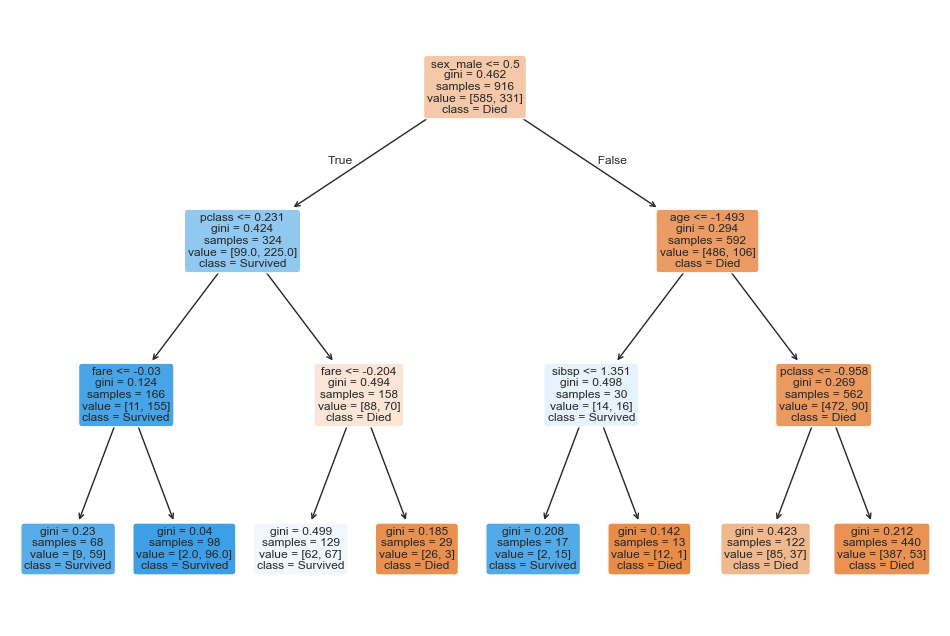

In [49]:
from sklearn.tree import plot_tree

# Plot the decision tree using plot_tree
fig, ax = plt.subplots(figsize=(12, 8)) # Set figure size
plot_tree(
    dt,                                 # The decision tree classifier
    feature_names=X.columns,            # Feature names
    class_names=["Died", "Survived"],   # Class names
    filled=True,                        # Use color to indicate classes
    rounded=True,                       # Rounded corners for nodes
    ax=ax                               # Axis to plot on
)

plt.show()                              # Display the plot

Root Node (Topmost Box): The root node is where the tree starts, and it represents the first (most important) split. 

* Here, the first split is based on `sex_male`, indicating whether the passenger is male. If `sex_male <= 0.5`, the passenger is likely female, and if `sex_male > 0.5`, they are male.
* The Gini impurity here is 0.462, indicating the degree of class impurity.
* `samples = 916` shows the number of observations reaching this node.
* `value = [585, 331]` gives the class distribution at this node — 585 died and 331 survived.
* The predicted class at this node is Died.

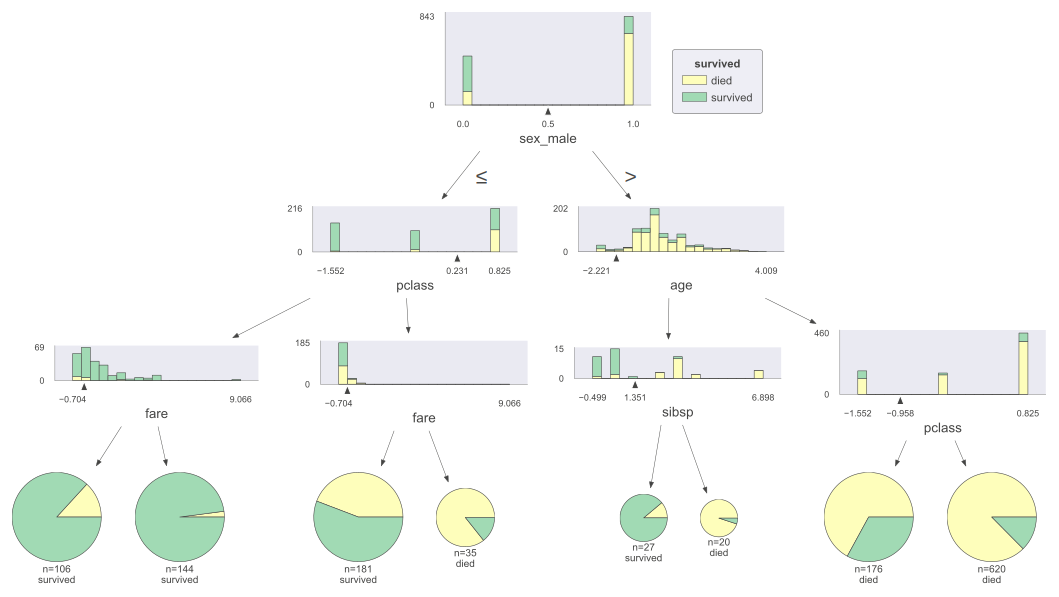

In [51]:
from dtreeviz import model 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Create the decision tree visualization model
viz = model(
    dt,                               # Trained decision tree model
    X.values,                         # Feature matrix as a 2D array
    y,                                # Target variable
    target_name="survived",           # Name for the target variable
    feature_names=X.columns.tolist(), # List of feature names
    class_names=["died", "survived"]  # Names for each class
)

# Display the visualization with an increased scale
viz.view(scale=1.5)                   # Adjust the scale as needed

Feature importance showing Gini importance (reduction of error by using that feature):

In [53]:
# Iterate over the top 5 most important features in descending order of importance
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),    # Pair each feature with its importance
    key=lambda x: x[1],                         # Sort by the importance value
    reverse=True,                               # Sort in descending order
)[:5]:                                          # Select the top 5 features
    print(f"{col:10}{val:10.3f}")               # Print feature name and importance value, formatted

sex_male       0.607
pclass         0.248
sibsp          0.052
fare           0.050
age            0.043


`sex_male`: 0.607 — This feature (whether the passenger is male) has the highest importance (60.7%), meaning it plays the largest role in predicting survival.

`pclass`: 0.248 — The passenger class (e.g., 1st, 2nd, 3rd class) contributes significantly (24.8%) to the model, second in importance.

`sibsp`: 0.052 — The number of siblings/spouses aboard accounts for 5.2% of the predictive power.

`fare`: 0.050 — The fare paid contributes 5.0%.

`age`: 0.043 — Age has the least importance among these top features, contributing 4.3%.

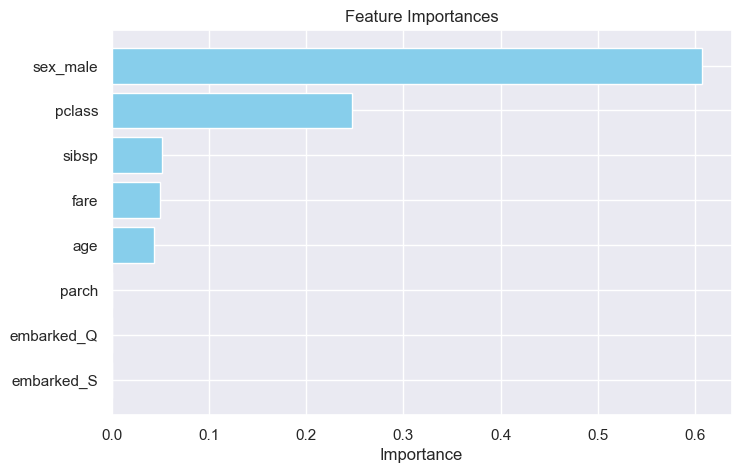

In [55]:
# Get feature importances and create a DataFrame for easy plotting
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

### Random Forest

A random forest is an ensemble of decision trees. It uses bagging to correct the tendency of decision trees to overfit. By creating many trees trained on random subsamples of the samples
and random features of the data, the variance is lowered.
    
Because they train on subsamples of the data, random forests
can evaluate OOB error and evaluate performance. They can
also track feature importance by averaging the feature importance over all of the trees.

The intuition for understanding bagging comes from a 1785
essay by Marquis de Condorcet. The essence is that if you are
creating a jury, you should add anyone who has a greater than
50% chance of delivering the correct verdict and then average
their decisions. Every time you add another member (and their
selection process is independent of the others), you will get a
better result.
    
The idea with random forests is to create a “forest” of decision
trees trained on different columns of the training data. If each
tree has a better than 50% chance of correct classification, you
should incorporate its prediction. The random forest has been
an excellent tool for both classification and regression, though
it has recently fallen out of favor for gradient-boosted trees.

In [57]:
from sklearn.ensemble import RandomForestClassifier 


# Instantiate the RandomForestClassifier with a fixed random state for reproducibility
rf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [58]:
# Evaluate the model on the test set and print the accuracy score
rf.score(X_test, y_test) 

0.7837150127226463

In [59]:
# Make a prediction for the first instance in X
rf.predict(X.iloc[[0]])

array([0], dtype=int64)

In [60]:
# Get the probability estimates for each class for the first instance in X
rf.predict_proba(X.iloc[[0]])

array([[0.9625, 0.0375]])

In [61]:
# Get the log of the probability estimates for each class for the first instance in X
rf.predict_log_proba(X.iloc[[0]])

array([[-0.03822121, -3.28341435]])

In [62]:
# Iterate over the top 5 most important features in descending order of importance
for col, val in sorted(
    zip(X.columns, rf.feature_importances_),  # Pair each feature with its importance   # <========= rf.feature_importances_
    key=lambda x: x[1],                       # Sort by the importance value
    reverse=True,                             # Sort in descending order
)[:5]:                                        # Select the top 5 features
    print(f"{col:10}{val:10.3f}")             # Print feature name and importance value, formatted

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050


**TIP**: 


The random forest classifier computes the feature importance by determining the mean decrease in impurity for
each feature (also known as Gini importance). Features
that reduce uncertainty in classification receive higher
scores.

These numbers might be off if features vary in scale or cardinality of categorical columns. A more reliable score is
permutation importance (where each column has its values
permuted and the drop in accuracy is measured). An even
more reliable mechanism is drop column importance
(where each column is dropped and the model is re-evaluated), but sadly this requires creating a new model for each
column that is dropped.

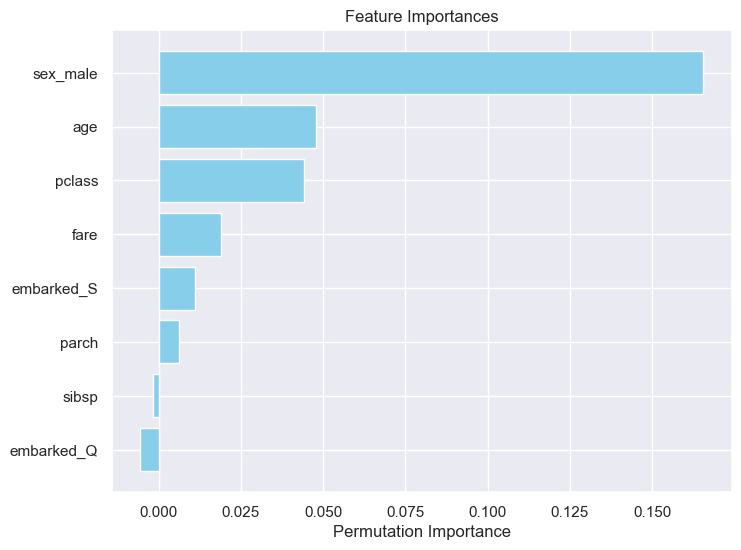

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


# Train the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importances
perm_importances = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)  # <========= permutation_importance

# Create a DataFrame to hold feature importances
feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importances.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Train the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importances
perm_importances = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)  # <========= permutation_importance

# Create a DataFrame to hold feature importances
feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importances.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the table of feature importances
feature_importances.reset_index(drop=True, inplace=True)
feature_importances

,Feature,Importance
0,sex_male,0.165564
1,age,0.047752
2,pclass,0.044105
3,fare,0.018914
4,embarked_S,0.011026
5,parch,0.006277
6,sibsp,-0.001781
7,embarked_Q,-0.005768


#### The discrepancy between the two methods arises because they measure feature importance differently:

`rf.feature_importances_`: This attribute provides the importance of each feature based on the average decrease in impurity (e.g., Gini impurity or entropy) in the decision tree splits. It measures how much each feature contributes to reducing uncertainty (or "impurity") in the model's nodes. This method is fast but can be biased toward features with more categories or higher variance.

`permutation_importance`: This method measures the importance by shuffling each feature and observing how much the model’s performance decreases. It’s more interpretable because it directly measures the effect of each feature on prediction accuracy but can take longer to compute due to multiple shuffling repetitions. It’s also generally more reliable for comparing features with different scales and types.

#### Summary of Results

`rf.feature_importances_` ranks `age` as the top feature, but this is based on the splits within the tree and does not account for shuffling.

`permutation_importance` ranks `sex_male` as the most important feature, with a high effect on prediction accuracy when shuffled.

### XGBoost

*XGBoost* is a popular library outside of scikit-learn. It creates a
weak tree and then “boosts” the subsequent trees to reduce the
residual errors. It tries to capture and address any patterns in
the errors until they appear to be random.

In [68]:
import xgboost as xgb

# Initialize the XGBClassifier with a fixed random state and early stopping rounds
xgb_class = xgb.XGBClassifier(random_state=42, early_stopping_rounds=10)  # Sets reproducibility and early stopping

# Train the XGBClassifier on the training data with a validation set for early stopping
xgb_class.fit(
    X_train,                     # Feature matrix for training
    y_train,                     # Labels for training
    eval_set=[(X_test, y_test)]  # Use test set as validation to monitor early stopping criteria
)

[0]	validation_0-logloss:0.57659
[1]	validation_0-logloss:0.52028
[2]	validation_0-logloss:0.49359
[3]	validation_0-logloss:0.48294
[4]	validation_0-logloss:0.47380
[5]	validation_0-logloss:0.46712
[6]	validation_0-logloss:0.46368
[7]	validation_0-logloss:0.46210
[8]	validation_0-logloss:0.46318
[9]	validation_0-logloss:0.46177
[10]	validation_0-logloss:0.45846
[11]	validation_0-logloss:0.45799
[12]	validation_0-logloss:0.45533
[13]	validation_0-logloss:0.45420
[14]	validation_0-logloss:0.45433
[15]	validation_0-logloss:0.45189
[16]	validation_0-logloss:0.44848
[17]	validation_0-logloss:0.44993
[18]	validation_0-logloss:0.44893
[19]	validation_0-logloss:0.44938
[20]	validation_0-logloss:0.45412
[21]	validation_0-logloss:0.45544
[22]	validation_0-logloss:0.45793
[23]	validation_0-logloss:0.45830
[24]	validation_0-logloss:0.45597
[25]	validation_0-logloss:0.45672
[26]	validation_0-logloss:0.45765


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [69]:
# Calculate and print the accuracy of the model on the test set
xgb_class.score(X_test, y_test)

0.8040712468193384

In [70]:
# Make a prediction for the first instance in the DataFrame X
xgb_class.predict(X.iloc[[0]])

array([0])

In [71]:
# Get the probability estimates for each class for the first instance in X
xgb_class.predict_proba(X.iloc[[0]]) 

array([[0.92349774, 0.07650226]], dtype=float32)

#### Gain-Based Feature Importance 

In [73]:
# Iterate over the top 5 most important features in descending order of importance
for col, val in sorted(
    zip(
        X.columns,                       # Column names of the feature matrix X
        xgb_class.feature_importances_,  # Feature importance scores from the trained XGBClassifier
    ),
    key=lambda x: x[1],                  # Sort by the importance value (second element in each tuple)
    reverse=True,                        # Sort in descending order to get the most important features first
)[:5]:                                   # Select the top 5 features based on importance
    print(f"{col:10}{val:10.3f}")        # Print each feature name and its importance value, formatted

sex_male       0.567
pclass         0.230
sibsp          0.068
fare           0.034
age            0.032


* `sex_male`: 0.567 — This feature (indicating if the passenger is male) has the highest importance, contributing significantly (56.7%) to the predictions.
  
* `pclass`: 0.230 — The passenger class (e.g., 1st, 2nd, 3rd class) has the second-highest importance, contributing 23.0%.
  
* `sibsp`: 0.068 — The number of siblings/spouses aboard the ship has a moderate impact, contributing 6.8%.
 
* `fare`: 0.034 — The ticket fare paid has a smaller influence, with 3.4%.
 
* `age`: 0.032 — Age has the least impact among these top features, with 3.2%.

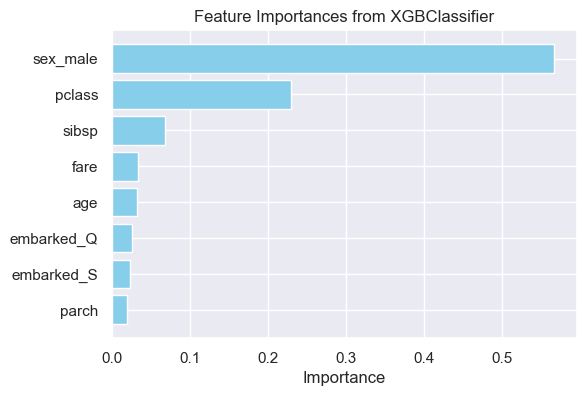

In [75]:
# Get feature importances from the trained model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_class.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(6, 4))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from XGBClassifier')
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

#### F Score (Split Count)

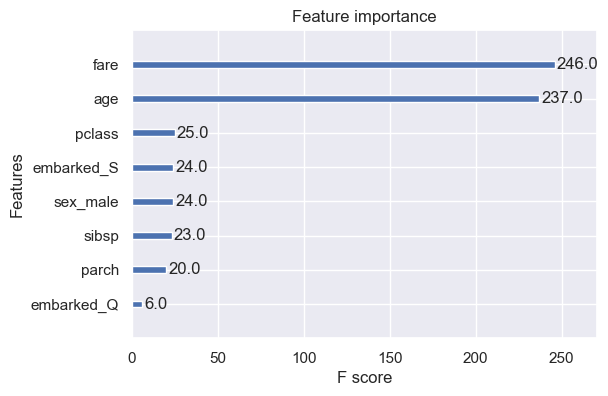

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))  # Create a figure and axes with specific dimensions
xgb.plot_importance(xgb_class, ax=ax);  # Plots the importances on the specified axes

#fig.savefig("images/mlpr_1005.png", dpi=300)

`fare`: This feature has the highest F score (246), meaning it was the most frequently used feature in splits. This suggests that fare has the strongest impact on the model's predictions.

`age`: With an F score of 237, age is also highly influential and was frequently used in the model.

**Gain-Based Feature Importance** (`feature_importances_`): This method calculates importance based on the average gain (improvement in purity) when the feature is used in a split. Here, sex_male has the highest importance, meaning it contributes most to improving the model's accuracy when used. Gain-based importance is often a more robust measure of a feature’s predictive power but may undervalue features that are split frequently but provide lower gains (like fare and age in this case).

**F Score (Split Count)**: This is what you see in the feature importance plot generated by `xgb.plot_importance`. It represents the number of times a feature was used in a split across all trees in the model. Features with higher F scores, like fare and age, were chosen more frequently for splits, but this does not necessarily mean they have the most significant impact on prediction accuracy. This measure can sometimes favor features with more unique values (continuous features) or high variance.

#### Why These Differences Occur
* `fare` and `age` are split frequently (high F score) because they might help create finer distinctions in the data, even if the gain per split is low.

* `sex_male` has a high gain importance, suggesting that splits on this feature lead to significant improvements in prediction accuracy.
    
#### Which Metric to Use?

* Gain-based importance (like the one from `feature_importances_`) is generally more reliable for understanding which features impact predictions most significantly.
  
* F score can provide insights into how often a feature is used but can sometimes overvalue features with many unique values or high variance.
For robust feature importance analysis, you might want to prioritize gain-based importance (from `feature_importances_`) over the F score.

XGBoost provides both a textual representation of the trees and a graphical one. Here is the text representation:

In [82]:
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[sex_male] yes=1,no=2
	1:[pclass<0.825247765] yes=3,no=4,missing=4
		3:leaf=0.717911363
		4:[fare<-0.202066973] yes=7,no=8,missing=8
			7:[age<-0.387676835] yes=13,no=14,missing=14
				13:[age<-0.517409861] yes=23,no=24,missing=24
					23:[age<-0.673487127] yes=37,no=38,missing=38
						37:leaf=0.321986973
						38:leaf=-0.274708062
					24:leaf=0.456491858
				14:[age<-0.166698784] yes=25,no=26,missing=26
					25:[fare<-0.352959305] yes=39,no=40,missing=40
						39:leaf=-0.29032445
						40:leaf=0.163437903
					26:[age<-0.166507855] yes=41,no=42,missing=42
						41:leaf=0.39276433
						42:leaf=0.0333611704
			8:[age<-0.499368906] yes=15,no=16,missing=16
				15:[age<-1.76602781] yes=27,no=28,missing=28
					27:leaf=-0.114519216
					28:leaf=-0.376673013
				16:leaf=-0.0633407906
	2:[age<-1.4538734] yes=5,no=6,missing=6
		5:[sibsp<1.35050142] yes=9,no=10,missing=10
			9:[age<-2.16272163] yes=17,no=18,missing=18
				17:leaf=0.163437903
				18:leaf=0.604846299
			10:leaf=-0.279815435


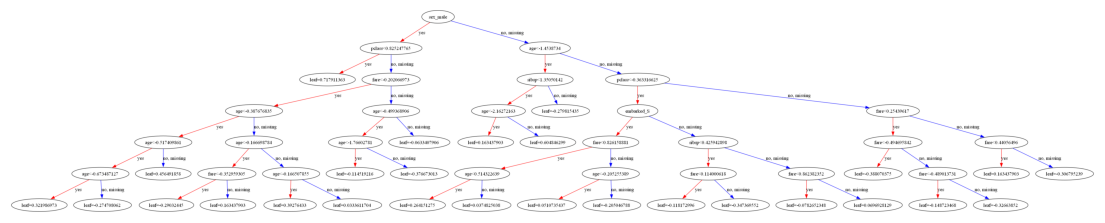

In [83]:
fig, ax = plt.subplots(figsize=(14, 12))       # Create a figure and axis with a specified size
xgb.plot_tree(xgb_class, ax=ax, num_trees=0);  # Plot the first tree in the XGBoost model
#fig.savefig("images/mlpr_1007.png", dpi=300)

In [84]:
import xgbfir

# Generate and save a feature interaction report for the XGBClassifier model
xgbfir.saveXgbFI(
    xgb_class,                               # The trained XGBoost model for which we want the feature interaction report
    feature_names=X.columns,                 # List of feature names to be used in the report for easy interpretation
    OutputXlsxFile="fir.xlsx",               # The output file path and name to save the report as an Excel file
)

# Load the generated Excel report and display the first 3 rows transposed for readability
pd.read_excel("fir.xlsx").head(3).T          # Reads the saved report, shows first 3 rows, and transposes for a vertical view

,0,1,2
Interaction,sex_male,fare,age
Gain,522.555901,320.634976,291.403577
FScore,24,246,237
wFScore,16.663171,65.110945,47.510318
Average wFScore,0.694299,0.264679,0.200465
Average Gain,21.773163,1.303394,1.229551
Expected Gain,518.004622,84.671456,72.020738
Gain Rank,1,2,3
FScore Rank,4,1,2
wFScore Rank,3,1,2


From this table, we see `sex_male` ranks high in gain, average
wFScore, average gain, and expected gain, whereas `fare` tops
out in FScore and wFScore. 

Let’s look at pairs of column interactions:

In [86]:
# Read the "Interaction Depth 1" sheet from the generated Excel report
pd.read_excel(
    "fir.xlsx",                       # Path to the Excel file generated by xgbfir
    sheet_name="Interaction Depth 1", # Specify the sheet containing first-level feature interactions
).head(2).T                           # Display the first 2 rows, transposed for easier readability

,0,1
Interaction,pclass|sex_male,age|sex_male
Gain,700.239306,552.98159
FScore,13,18
wFScore,4.538845,6.158882
Average wFScore,0.349142,0.34216
Average Gain,53.864562,30.721199
Expected Gain,259.60394,339.208963
Gain Rank,1,2
FScore Rank,13,8
wFScore Rank,7,5


Here we see that the top two interactions involve the `sex_male`
column in combination with pclass and age. If you were only
able to make a model with two features, you would probably
want to choose `pclass` and `sex_male`.

Finally, let’s look at triplets:

In [88]:
# Read the "Interaction Depth 2" sheet from the generated Excel report
pd.read_excel(
    "fir.xlsx",                       # Path to the Excel file generated by xgbfir
    sheet_name="Interaction Depth 2", # Specify the sheet containing second-level feature interactions
).head(1).T                           # Display the first row, transposed for easier readability

,0
Interaction,fare|pclass|sex_male
Gain,977.738793
FScore,21
wFScore,4.09411
Average wFScore,0.194958
Average Gain,46.55899
Expected Gain,181.281345
Gain Rank,1
FScore Rank,7
wFScore Rank,7


This is only showing the first triplet due to space limitations,
but the spreadsheet has many more:

In [90]:
# Read the "Interaction Depth 2" sheet and select specific columns for display
pd.read_excel(
    "fir.xlsx",                       # Path to the Excel file generated by xgbfir
    sheet_name="Interaction Depth 2", # Specify the sheet containing second-level feature interactions
)[["Interaction", "Gain"]].head()     # Select and display the "Interaction" and "Gain" columns, showing the first 5 rows

,Interaction,Gain
0,fare|pclass|sex_male,977.738793
1,age|sex_male|sibsp,579.891778
2,age|pclass|sex_male,536.860189
3,age|fare|pclass,431.618079
4,age|age|fare,279.552229


### Gradient Boosted with LightGBM

LightGBM is an implementation by Microsoft. LightGBM uses
a sampling mechanism to deal with continuous values. This
allows quicker creation of trees (than say XGBoost), and
reduces memory usage.
    
LightGBM also grows trees depth first (leaf-wise rather than
level-wise). Because of this, rather than using `max_depth` to
control overfitting, use `num_leaves` (where this value is
< 2^(max_depth)).

In [93]:
import lightgbm as lgb 

# Initialize the LightGBM Classifier with a fixed random state for reproducibility
lgbm_class = lgb.LGBMClassifier(random_state=42)

# Train the LGBMClassifier on the training data
lgbm_class.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 331, number of negative: 585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.361354 -> initscore=-0.569493
[LightGBM] [Info] Start training from score -0.569493


LGBMClassifier(random_state=42)

In [94]:
# Evaluate the model's accuracy on the test set
lgbm_class.score(X_test, y_test) 

0.7862595419847328

In [95]:
# Make a prediction for the first instance in the DataFrame X
lgbm_class.predict(X.iloc[[0]]) 

array([0], dtype=int64)

In [96]:
# Get the probability estimates for each class for the first instance in X
lgbm_class.predict_proba(X.iloc[[0]])

array([[0.97943185, 0.02056815]])

Feature importance based on 'splits' (number of times a
product is used):

In [98]:
# Iterate over the top 5 most important features in descending order of importance
for col, val in sorted(
    zip(cols, lgbm_class.feature_importances_),  # Pair each feature name with its importance score from the LGBMClassifier
    key=lambda x: x[1],                          # Sort by the importance score (second element in each tuple)
    reverse=True,                                # Sort in descending order to show the most important features first
)[:5]:                                           # Select only the top 5 features based on importance
    print(f"{col:10}{val:10.3f}")                # Print each feature name and its importance value, formatted for readability

age         1254.000
fare        1226.000
pclass       117.000
embarked_S   100.000
sibsp         89.000


    age: 1254.000 — The age feature was used 1,254 times in splits, indicating that it has a high impact on the model’s predictions.
    fare: 1226.000 — fare was used 1,226 times in splits, making it another highly influential feature.

The LightGBM library supports creating a feature importance
plot. The default is based on 'splits', the
number of times a feature is used. You can specify
'importance_type' if you want to change it to 'gain':

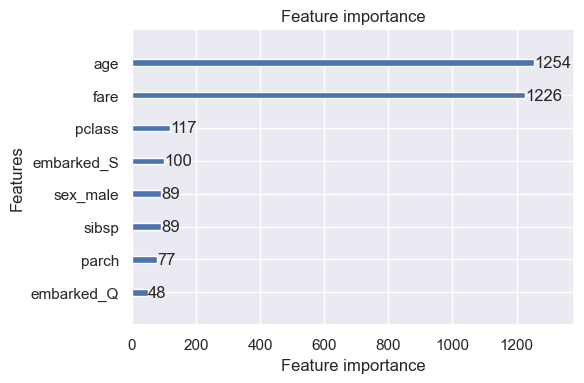

In [101]:
# Create a figure and axis with specified dimensions for the feature importance plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot feature importances using LightGBM's plot_importance function
lgb.plot_importance(lgbm_class, ax=ax)

# Adjust layout to prevent overlap and ensure a neat display of the plot elements
fig.tight_layout()

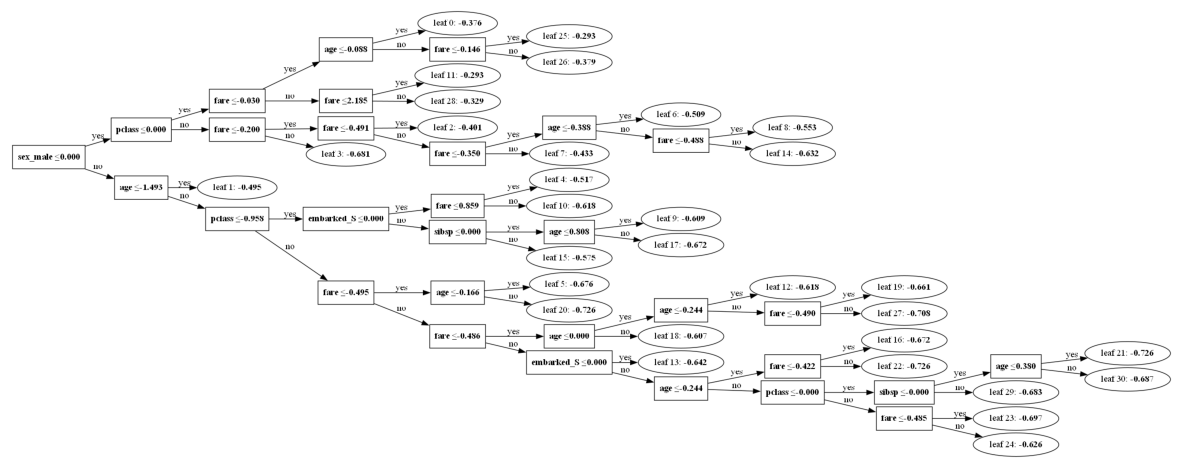

In [102]:
# Create a figure and axis with a specified size for better visibility of the tree
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the first tree in the trained LGBMClassifier model
lgb.plot_tree(lgbm_class, tree_index=0, ax=ax);

# fig.savefig("images/mlpr_1009.png", dpi=300)

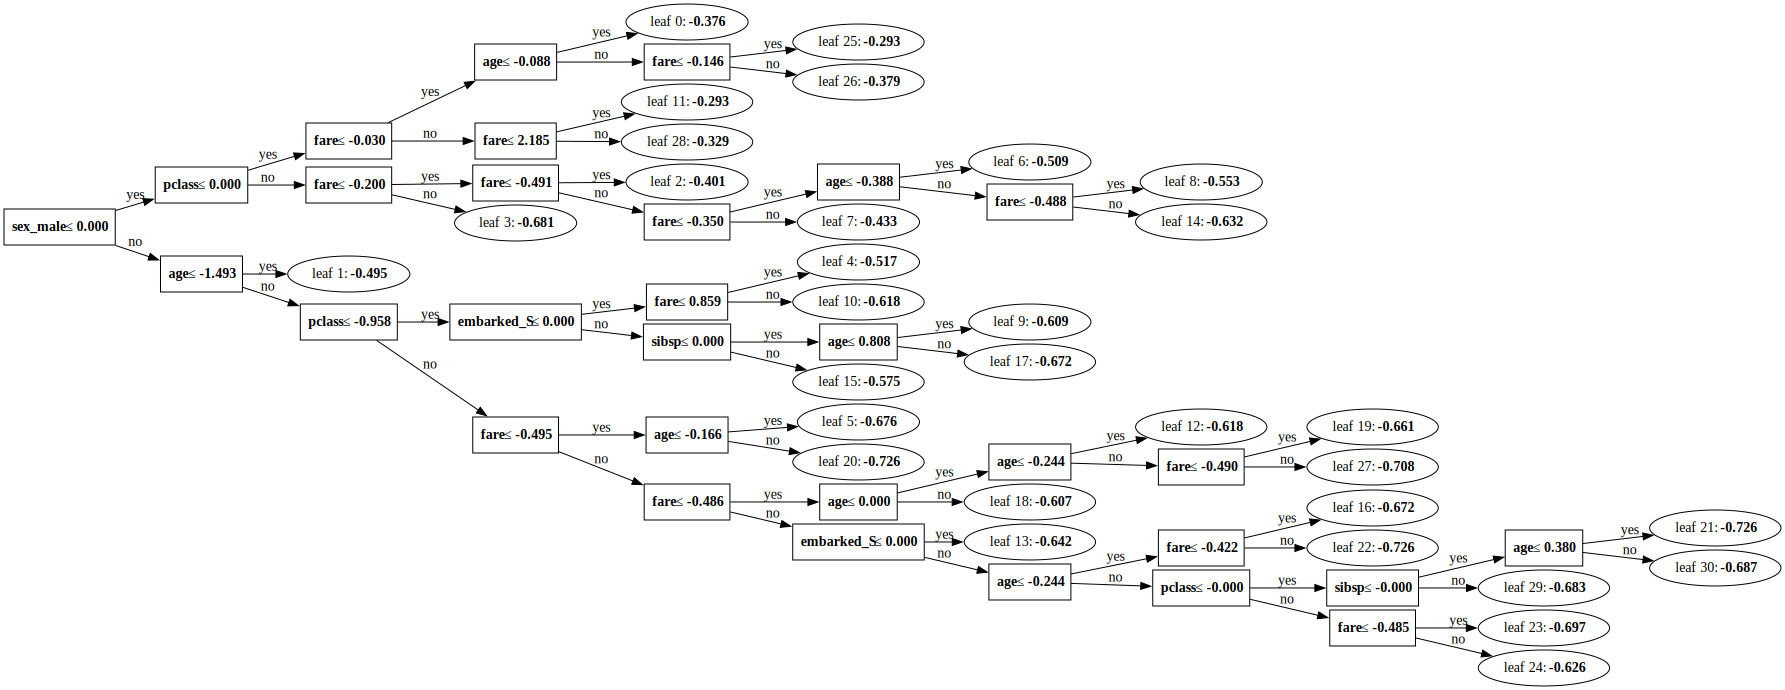

In [103]:
# View a tree
lgb.create_tree_digraph(lgbm_class)

Negative values in the tree nodes are part of the internal scoring mechanism and represent log-odds adjustments rather than feature values or class labels. Our feature values appear negative due to transformations applied before training (scalling).